In [1]:
from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [2]:
print(x_train.shape, y_train.shape)

(404, 13) (404,)


In [3]:
print(x_test.shape, y_test.shape)

(102, 13) (102,)


In [4]:
import matplotlib.pyplot as plt

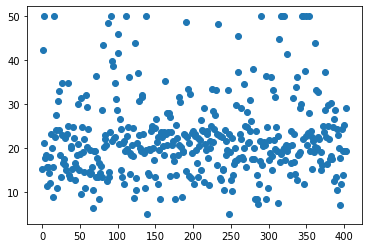

In [5]:
plt.scatter(range(len(y_train)), y_train)

In [6]:
import numpy as np

samples = np.asarray(y_train.reshape(404,1)).astype('float64')
samples = np.concatenate((x_train, samples), axis=1)

NameError: name 'np' is not defined

So from my perspective, there are 4 main price ranges and I'm gonna label the data according to them

In [ ]:
def convert_labels(y):
    labels = np.zeros(len(y))

    for i, price in enumerate(y):
        if price<15:
           labels[i]=0
        elif price>=15 and price<25:
            labels[i]=1
        elif price>=25 and price<40:
            labels[i]=2
        else:
            labels[i]=3
    
    return labels

In [ ]:
labels_train = convert_labels(y_train)

Now I'm gonna use t-SNE to visualize data points and see if they make clusters or not.

In [ ]:
from sklearn.manifold import TSNE
import pandas
from plotly import express as px
import numpy as np

In [ ]:
tsne_2d = TSNE(n_components=2, random_state=0)
projections_2d = tsne_2d.fit_transform(x_train)
fig_2d = px.scatter(projections_2d, x=0, y=1,
                   color=labels_train.astype(str),
                    labels={'color': 'range'})
fig_2d.show()

The first price range below 15 forms a pretty clear cluster on the upper left.

The second one from 15 to 25 form 2 clusters, one of which kind of blends with the first group and the second one is at the lower right.

The third one from 25 to 40 forms a small cluster at the lower right but still distinguishable from the second one.

The last one above 40 is looks kind of random.

Anyway, this is just for me to test t-SNE. It has nothing to do with the network and probably does not help me get any useful information out it. But it is fun though.

Now, to the real deal.

First we have to normalize the data so that it is centered around 0 with a standard deviation of 1. Each feature (collumn) is subtracted by the mean and divide by the standard deviation.

In [ ]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /=std

x_test -= mean
x_test /= std

In [ ]:
from keras import models, layers

# The model is reused so a function is defined
def build_network():

    network = models.Sequential()
    network.add(layers.Dense(64, activation='relu',
                             input_shape=(x_train.shape[1], )))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    # the last layer predicts the price, no need for activation

    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    # loss function here is mean squared error
    # widely used for regression problems
    
    # metrics is mean absolute error
    # the difference between the prediction and the target

    return network

New validating approach: K-fold cross validation

In the previous examples where keras' default validation_split is used, the validation scores might change a lot depending on which data
points get chosen for validation and which for training. This would prevent you from reliably evaluating your model.

K-fold cross validation is when the data is partitioned into k parts, each part would be used for validation once while the model is trained with the rest. The average of all validation scores obtained is the result.

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
num_epochs = 300
all_mae_histories = []

for train, test in kfold.split(x_train, y_train):
    network = build_network()
    history = network.fit(x_train[train], y_train[train], epochs=num_epochs,
                   batch_size=16,
                   validation_data=(x_train[test], y_train[test]),
                    verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Now we plot the mean absolute error to see how it varies. We can see that the first 20 points are just plummeting while the rest seems to lie in the same range. So we omit the first 20 points to get a better grasp of how the MAE changes.

In [ ]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


# avg_mae_history = avg_mae_history[20:]

import matplotlib.pyplot as plt
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The graph's high variahance makes it hard to detect the desired point. Therefore we smooth it out by passing it through a lowpass filter. Now it is obvious that after the 150th epoch, the MAE does not improve much. Therefore, we stop trainig after 150 epochs.

In [ ]:
from scipy.fft import fft, ifft, fftshift
from scipy import signal

sos = signal.cheby1(14, 1, 0.1, btype='lowpass', output='sos')
filtered = signal.sosfilt(sos, avg_mae_history)
plt.plot(filtered)
plt.show()

In [ ]:
network = build_network()
network.fit(x_train, y_train, epochs=150, batch_size=16)
results = network.evaluate(x_test, y_test)

In [ ]:
print(results)